# Machine Learning
### Laboratory 9

### **Drug Dataset**

### **Business Understanding**

- Scenario
    - A medical division collected some data from its patients
    - All the target patients contracted the same disease
    - The therapy consists of 5 different and exclusive cures
        - Each cure depends on the patients’ conditions
- Goal
    - Define an automatic procedure for the cure assignment 

### **Data Understanding**

| Column Name                   	| Description                                                                                                     	| Type                      	|
|-------------------	|------------------------------------------------	|-----------------      	|
| ID               	| Patient’s ID                    	|  Numeric                      	|
| Age               	| Patient’s age                 	|  Numeric             	|    
| Sex                	| Patient’s gender: F or M      	|  Binary                      	|
|      BP        	|        Blood Pressure: HIGH, NORMAL or LOW       	|   Categorical                       	|
|       Cholesterol         	|   Concentration of cholesterol in the blood: NORMAL or HIGH          	|   Binary    	|
|     Na           	|    Concentration of sodium in the blood       |     Numeric                    | 
|     K          	|   Concentration of potassium in the blood        	|   Numeric                       	|
|     Drug          	|      The chosen cure: drugY, drugC, drugX, drugA, drugB            	|      Categorical                    	|

In [1]:
import pandas as pd

In [2]:
drug = pd.read_csv("drug.csv", na_values="?")
drug

,ID,Age,Sex,BP,Cholesterol,Na,K,Drug
0,1,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,2,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,3,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,4,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,5,61,F,LOW,HIGH,0.559294,0.030998,drugY
...,...,...,...,...,...,...,...,...
195,196,56,F,LOW,HIGH,0.848774,0.073380,drugC
196,197,16,M,LOW,HIGH,0.743021,0.061886,drugC
197,198,52,M,NORMAL,HIGH,0.549945,NaN,drugX
198,199,23,M,NORMAL,NORMAL,0.784520,NaN,drugX


In [3]:
drug.isna().sum()

ID             0
Age            0
Sex            0
BP             0
Cholesterol    0
Na             6
K              4
Drug           0
dtype: int64

In [4]:
#null values are pretty few, for integrity's sake we can just drop those values ...
drug.dropna(inplace=True)
drug.drop("ID", axis=1,inplace=True)

In [5]:
#now I need to convert categorical variables
catv = ["Sex","BP", "Cholesterol","Drug"]
for c in catv:
    drug[c] = pd.Categorical(drug[c])

In [6]:
drug.dtypes

Age               int64
Sex            category
BP             category
Cholesterol    category
Na              float64
K               float64
Drug           category
dtype: object

Now let's check data with some cool visualizations!

In [7]:
import seaborn as sn

In [8]:
ordered_drugs = drug["Drug"].unique() ;

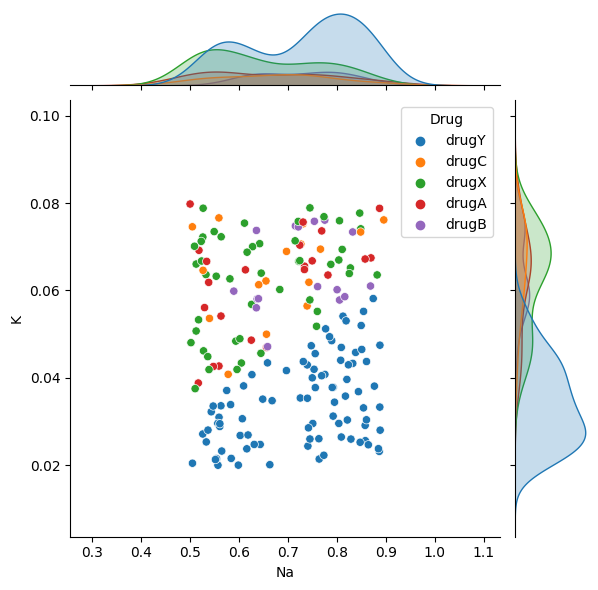

In [9]:
sn.jointplot(
    drug,
    x="Na",
    y="K",
    hue="Drug",
    hue_order=ordered_drugs
) ; 

We can already see that drugY is usually given to people with lower potassium values.

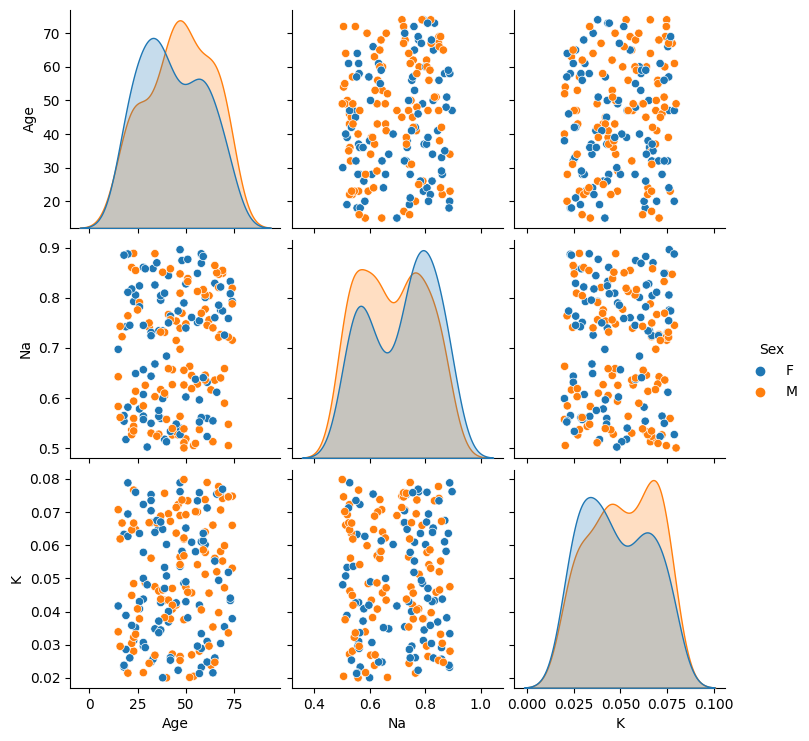

In [10]:
sn.pairplot(
    data=drug,
    hue = "Sex"
) ;

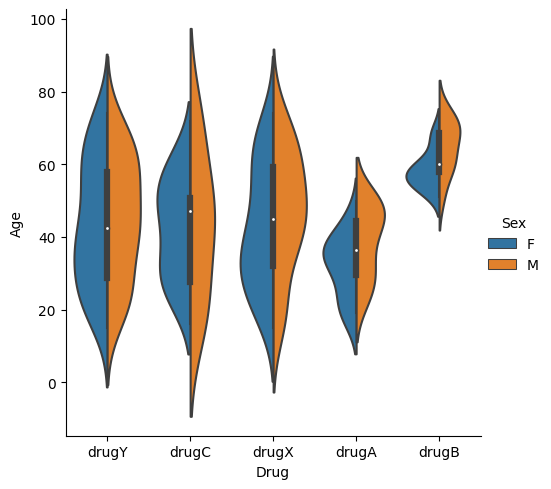

In [11]:
sn.catplot(
    drug,
    kind = "violin",
    x = "Drug",
    y = "Age",
    hue = "Sex",
    box = True,
    split = True,
    order=ordered_drugs
) ;

It is relevant to note the age distribution of drugs based on the sex.

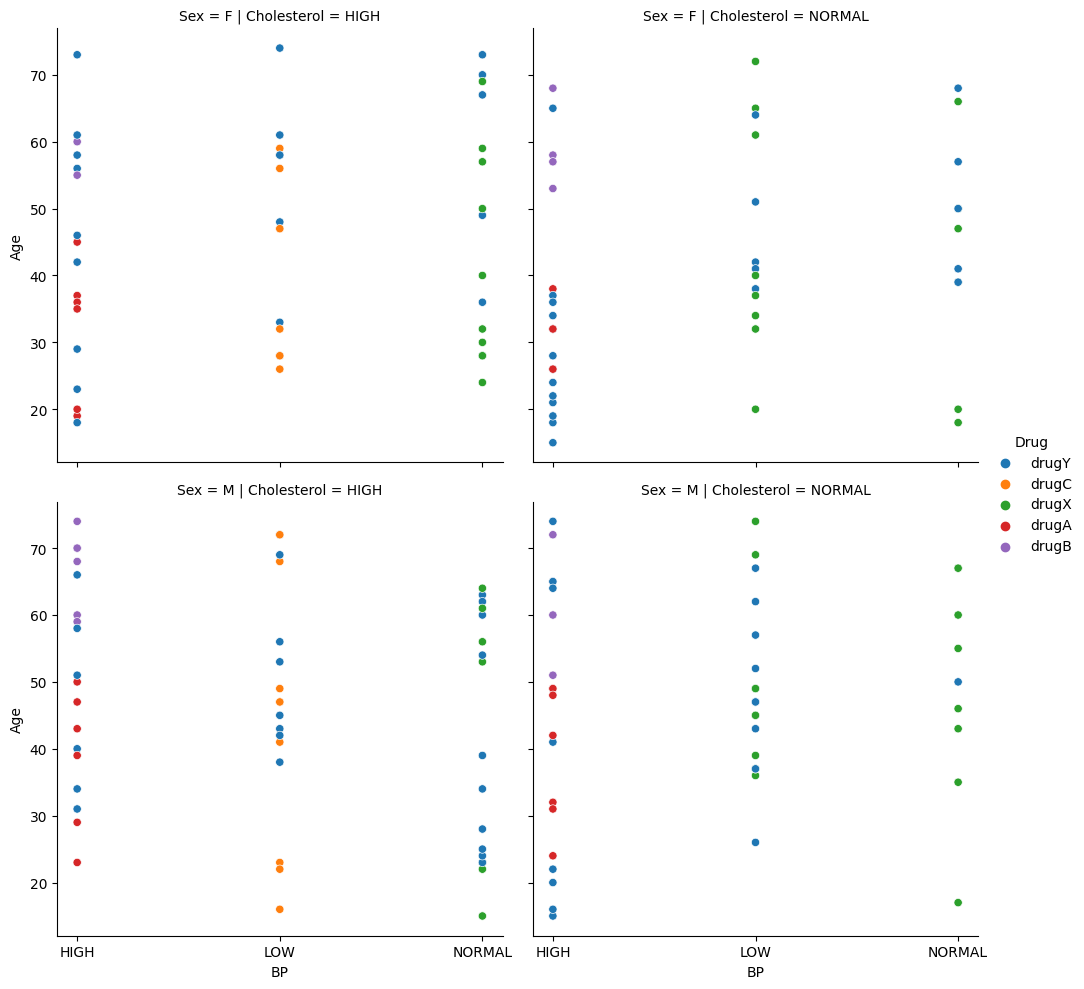

In [12]:
sn.relplot(
    data = drug,
    x = "BP",
    y = "Age",
    col = "Cholesterol",
    row = "Sex",
    hue = "Drug",
    hue_order=ordered_drugs
) ;

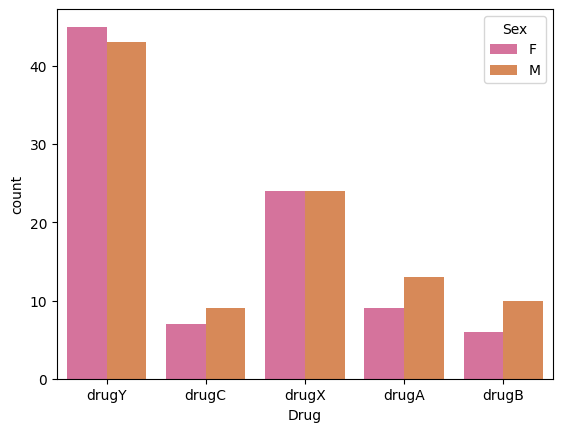

In [13]:
testpal = sn.blend_palette(["#E56399","#EC8443"], n_colors=2)

sn.countplot(
    drug,
    x = "Drug",
    hue = "Sex",
    order=ordered_drugs,
    palette=testpal
) ;

Classes are not really balanced! We must check on this in the model evaluation process

### **Data Preparation**

In [14]:
#lets quickly check categories ...
drug["Cholesterol"].unique()

['HIGH', 'NORMAL']
Categories (2, object): ['HIGH', 'NORMAL']

In [15]:
drug["BP"].unique()

['HIGH', 'LOW', 'NORMAL']
Categories (3, object): ['HIGH', 'LOW', 'NORMAL']

It is required to encode BP,Sex and Cholesterol with binary variables (One Hot Encoding)

In [16]:
drug = pd.get_dummies(data=drug, columns=['BP','Sex','Cholesterol'])
drug

,Age,Na,K,Drug,BP_HIGH,BP_LOW,BP_NORMAL,Sex_F,Sex_M,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,0.792535,0.031258,drugY,True,False,False,True,False,True,False
1,47,0.739309,0.056468,drugC,False,True,False,False,True,True,False
2,47,0.697269,0.068944,drugC,False,True,False,False,True,True,False
3,28,0.563682,0.072289,drugX,False,False,True,True,False,True,False
4,61,0.559294,0.030998,drugY,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
193,72,0.504820,0.074573,drugC,False,True,False,False,True,True,False
194,46,0.773569,0.022302,drugY,True,False,False,True,False,True,False
195,56,0.848774,0.073380,drugC,False,True,False,True,False,True,False
196,16,0.743021,0.061886,drugC,False,True,False,False,True,True,False


I think it's ok to test this without any standardization, then we can evaluate the models at the end and consider some further transformations if they seems to be required.

Finally, we only need to split our dataset into training and evaluation sets.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
targetDrug = drug["Drug"]
#extracting labels, will be useful for further visualization in models evaluation phase ...
lbls = targetDrug.unique()

seed = 122
testsize = 0.3 
drug.drop("Drug",axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(drug,targetDrug,test_size=testsize, random_state=seed)


### **Modeling**

We are going to exploit different models, in particular:
- Decision Tree classifier
- Random Forest Classifier
- Logistic regressor

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

In [20]:
x_train

,Age,Na,K,BP_HIGH,BP_LOW,BP_NORMAL,Sex_F,Sex_M,Cholesterol_HIGH,Cholesterol_NORMAL
111,47,0.526835,0.078828,False,False,True,True,False,False,True
110,50,0.518285,0.069193,True,False,False,False,True,True,False
60,38,0.598753,0.020042,False,True,False,True,False,False,True
77,26,0.823793,0.042994,True,False,False,True,False,False,True
153,72,0.758600,0.051810,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
66,29,0.625272,0.048637,True,False,False,False,True,True,False
81,64,0.512600,0.066049,False,False,True,False,True,True,False
190,58,0.769090,0.040497,True,False,False,False,True,True,False
146,37,0.804155,0.066981,False,True,False,True,False,False,True


In [21]:
dtmodel = DecisionTreeClassifier(random_state=seed)
dtmodel.fit(x_train,y_train) ;

In [22]:
rfmodel = RandomForestClassifier(random_state=seed)
rfmodel.fit(x_train,y_train) ;

In [23]:
logitmodel = LogisticRegression(random_state = seed) ;
logitmodel.fit(x_train,y_train) ;

#note that with default iterations size (100) and default solver (lbfgs) the model gives back a warning, suggesting to scale! 

/home/maiku/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### **Evaluation**

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [25]:
#now we can predict and evalutate the testset!
dtpredictions = dtmodel.predict(x_test)
rfpredictions = rfmodel.predict(x_test)
logitpredictions = logitmodel.predict(x_test)


In [26]:
dtmatrix = confusion_matrix(dtpredictions, y_test)
rfmatrix = confusion_matrix(rfpredictions, y_test)
logitmatrix = confusion_matrix(logitpredictions, y_test)

In [27]:
print(f"Decision Tree accuracy: {accuracy_score(dtpredictions, y_test)}")
print(f"Random Forest accuracy: {accuracy_score(rfpredictions, y_test)}")
print(f"Logistic regr accuracy: {accuracy_score(logitpredictions, y_test)}")

Decision Tree accuracy: 0.8771929824561403
Random Forest accuracy: 0.8947368421052632
Logistic regr accuracy: 0.43859649122807015


In [47]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [58]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Heatmap(z=confusion_matrix(dtpredictions,y_test),
                                    x=lbls,
                                    y=lbls
                                    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Heatmap(z=confusion_matrix(rfpredictions,y_test),
                                    x=lbls,
                                    y=lbls
                                    ),
    row=1,
    col=2
)

fig.add_trace(
    go.Heatmap(z=confusion_matrix(logitpredictions,y_test),
                                    x=lbls,
                                    y=lbls
                                    ),
    row=1,
    col=3
)

fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10),
    paper_bgcolor="lemonchiffon",
)

fig.update_yaxes(ticksuffix = "  ") 

fig.show()

Even if with problems, the graph above shows that there are a few problems with the logit model. Probably it is due to the fact that I didn't scale the training set (warning given during training)
However, I've got a couple of solid models, so it is not needed to further improve the logit one.